In [1]:
import os
import numpy as np
import mne
from pathlib import Path
from mne.preprocessing import ICA
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
import matplotlib.pyplot as plt

# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa

# Charger les données brutes

In [2]:
sample_data_folder = 'D:/Stage_M2/'
sample_data_raw_file = sample_data_folder + 'SBallonge.bdf'
raw = mne.io.read_raw_bdf(sample_data_raw_file,preload=True)

Extracting EDF parameters from D:\Stage_M2\SBallonge.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 933887  =      0.000 ...   911.999 secs...


In [ ]:
# Chemins des fichiers à concaténer
sample_data_folder = 'D:/Stage_M2_Paul/'

file1 = sample_data_folder + 'ALallonge.bdf'
file2 = sample_data_folder + 'ALallonge2.bdf'

# Lecture des fichiers bruts
raw1 = mne.io.read_raw_bdf(file1, preload=True)
raw2 = mne.io.read_raw_bdf(file2, preload=True)

# Concaténation des fichiers bruts
raw = mne.concatenate_raws([raw1, raw2])

# Affichage des informations du fichier concaténé
print(raw.info)

In [3]:
# change les noms des électrodes
channel_renaming_dict = {'A1':'Fp1','A2':'AF7','A3':'AF3','A4':'F1','A5':'F3','A6':'F5','A7':'F7','A8':'FT7','A9':'FC5',
                        'A10':'FC3','A11':'FC1','A12':'C1','A13':'C3','A14':'C5','A15':'T7','A16':'TP7','A17':'CP5',
                        'A18':'CP3','A19':'CP1','A20':'P1','A21':'P3','A22':'P5','A23':'P7','A24':'P9','A25':'PO7','A26':'PO3','A27':'O1','A28':'Iz','A29':'Oz','A30':'POz','A31':'Pz','A32':'CPz','B1':'Fpz','B2':'Fp2','B3':'AF8','B4':'AF4','B5':'AFz','B6':'Fz','B7':'F2','B8':'F4','B9':'F6',
                        'B10':'F8','B11':'FT8','B12':'FC6','B13':'FC4','B14':'FC2','B15':'FCz','B16':'Cz','B17':'C2','B18':'C4','B19':'C6','B20':'T8','B21':'TP8','B22':'CP6','B23':'CP4','B24':'CP2','B25':'P2','B26':'P4','B27':'P6','B28':'P8','B29':'P10','B30':'PO8','B31':'PO4','B32':'O2',}
raw.rename_channels(channel_renaming_dict)

<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

In [ ]:
# Visualiser données brutes
raw.plot()

## Types de capteurs et montage

In [4]:
# Marque les électrodes de références
raw.set_channel_types(mapping={'IOd': 'eog'})
raw.set_channel_types(mapping={'IOg': 'eog'})
raw.set_channel_types(mapping={'SOd': 'eog'})
raw.set_channel_types(mapping={'SCMd': 'emg'})
raw.set_channel_types(mapping={'SCMg': 'emg'})
raw.set_channel_types(mapping={'Sternum': 'ecg'})
raw.set_channel_types(mapping={'Eard': 'bio'})
raw.set_channel_types(mapping={'Earg': 'bio'})
montage = mne.channels.make_standard_montage('biosemi64')
print(montage)
raw.set_montage(montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>


<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

# Electrodes

In [5]:
# Marque les électrodes bruitées
raw.info['bads'] = ['P1', 'PO3', 'Pz', 'TP7','FT8','TP8']

In [6]:
raw_interp = raw.interpolate_bads()
raw_interp

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors


<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

In [7]:
raw_interp.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

In [ ]:
raw_interp.plot()

In [8]:
picks_eeg = mne.pick_types(raw_interp.info, meg=False, eeg=True, eog=False, emg=False, stim=False,
                       exclude='bads')
picks_eog = mne.pick_types(
    raw_interp.info, meg=False, eeg=False, eog=True, emg=False, stim=False,
                       exclude='bads')
picks_emg = mne.pick_types(raw_interp.info, meg=False, eeg=False, eog=True,  emg=True, stim=False,
                       exclude='bads')

In [9]:
#Apply x(-1) to Status channel to correctly detect triggers afterwards with find_events()
raw_interp.apply_function(np.negative,picks=['Status'])

<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

# Filtre données brutes

In [10]:
# filtrer le signal (passe-haut puis passe-bas)
raw_interp.filter(l_freq=1, h_freq=None) #always apply high pass filter first !

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.4s finished


<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

In [11]:
raw_interp.filter(l_freq=None, h_freq=200) #then apply low pass filter to get band passed data

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 69 samples (0.067 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.1s finished


<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

In [12]:
raw_bandpass = raw_interp
raw_bandpass

<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

In [ ]:
# Appliquer un filtre notch à 50 Hz
raw_bandpass.notch_filter(50)
raw_bandpass.notch_filter(100)
raw_bandpass.notch_filter(150)
raw_bandpass.notch_filter(200)

# Events

In [13]:
#find events
events = mne.find_events(raw_bandpass,stim_channel='Status',uint_cast=True)
print(events.shape)


#annote raw data with triggers
annot_from_events = mne.annotations_from_events(
    events=events, sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
raw.set_annotations(annot_from_events)
#annote raw data with triggers
annot_from_events = mne.annotations_from_events(
    events=events, sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
raw.set_annotations(annot_from_events)
# exclure les pauses comme "bad signal"
break_annots = mne.preprocessing.annotate_break(
    raw=raw,
    min_break_duration=4,  # consider segments of at least 20 s duration
    t_start_after_previous=0.4,  # start annotation 5 s after end of previous one
    t_stop_before_next=0.05  # stop annotation 2 s before beginning of next one
)
raw.set_annotations(raw.annotations + break_annots)  # add to existing
#rename triggers
event_dict = {'500Hz105dB': 2,
              '2500Hz105dB': 5, 
              '500Hz60dB': 3,
              'mask500Hz90dB': 9 }

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
2400 events found
Event IDs: [2 3 5 9]
(2400, 3)
Ignoring annotations with descriptions starting with: bad, edge

Detected 7 break periods of >= 4 sec duration:
    0.0 – 9.8 sec [9.8 sec]
    149.5 – 159.6 sec [10.1 sec]
    298.7 – 309.7 sec [11.0 sec]
    449.2 – 459.7 sec [10.5 sec]
    600.2 – 613.4 sec [13.2 sec]
    753.3 – 765.8 sec [12.5 sec]
    906.5 – 912.0 sec [5.5 sec]
In total, 8.0% of the data (72.7 sec) have been marked as a break.



In [14]:
# Visualiser les données filtrées avec les évènements et pauses (enlever bad segments s'il le faut)
raw_bandpass.plot()

Using qt as 2D backend.


Channels marked as bad:
none


In [15]:
#sauvegarder raw_bandpass
raw_bandpass.save('D:/Stage_M2/SBallonge_bad_seg_eeg.fif')

Writing D:\Stage_M2\SBallonge_bad_seg_eeg.fif
Closing D:\Stage_M2\SBallonge_bad_seg_eeg.fif
[done]


# ICA

In [16]:
n_components = 25  # if float, select n_components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we need sufficient statistics, not all time points -> saves time
# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutor
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, method: fastica>


In [17]:
# Décompose le signal raw_bandpass en 25 composantes sur les 64 électrodes
ica.fit(raw_bandpass, picks=picks_eeg, decim=decim)
print(ica)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 74429 of 933888 (7.97%) samples, retaining 859459 (92.03%) samples.
Selecting by number: 25 components
Fitting ICA took 18.3s.
<ICA | raw data decomposition, method: fastica (fit in 65 iterations on 286487 samples), 25 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>


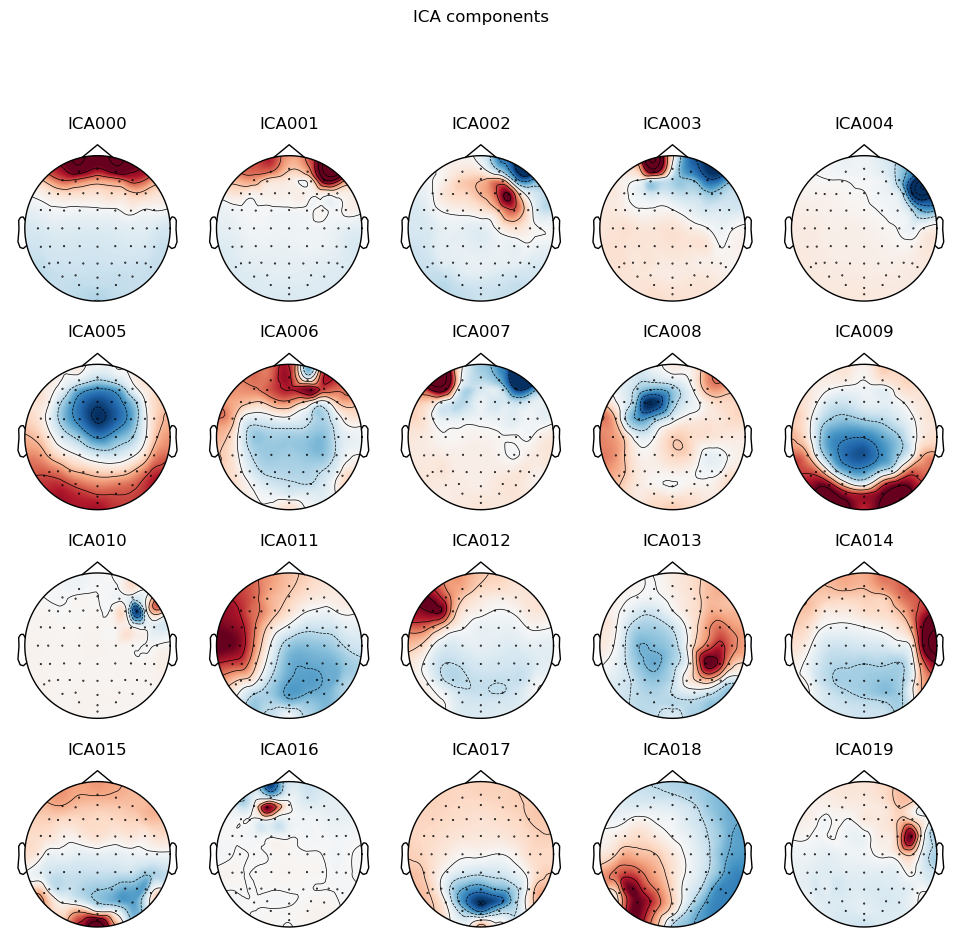

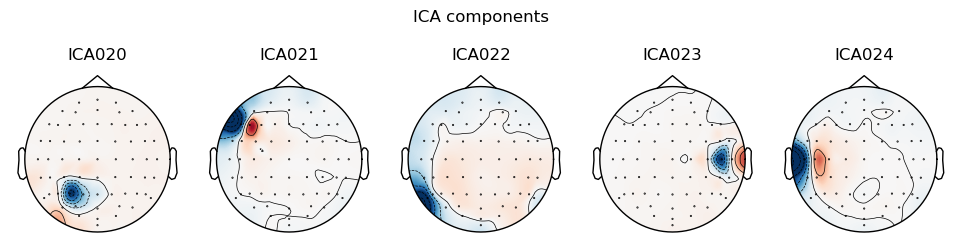

In [18]:
# Visualiser les ICAs topographie
ica.plot_components();

# Trouve et retire les composantes corrélées avec mvt des yeux

Using EOG channels: IOd, IOg, SOd
EOG channel index for this subject is: [67 68 71]
Omitting 74429 of 933888 (7.97%) samples, retaining 859459 (92.03%) samples.
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected: 2
Not setting metadata
2 matching events found
No baseline correction applied
Using data from preloaded Raw for 2 events and 1025 original time points ...
1 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 74429 of 933888 (7.97%) samples, retaining 859459 (92.03%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 74429 of 933888 (7.97%) samples, retaining 859459 (92.03%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 74429 of 933888 (7.97%) samples, retaining 859459 (92.03%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


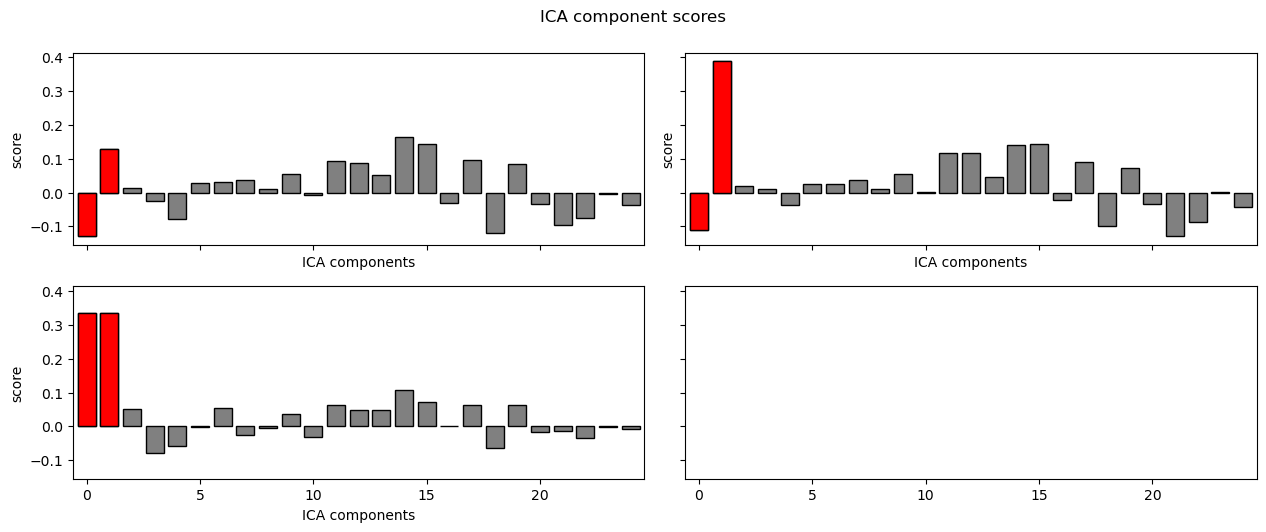

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
416 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
416 matching events found
No baseline correction applied
0 projection items activated


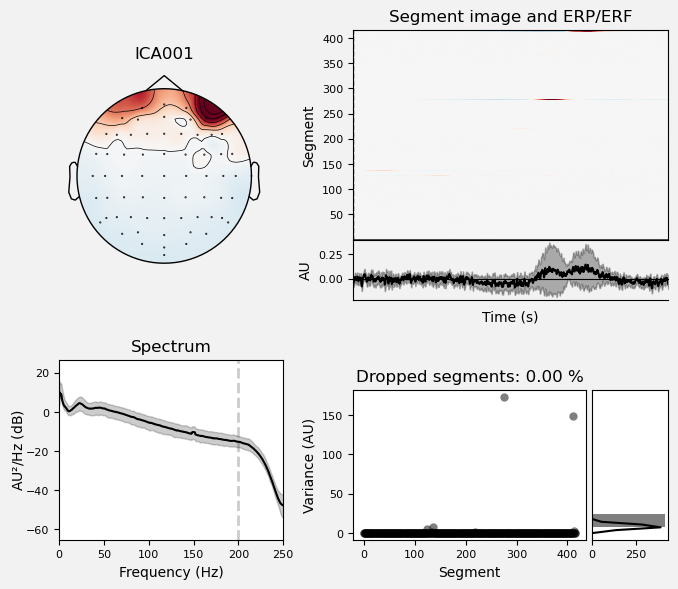

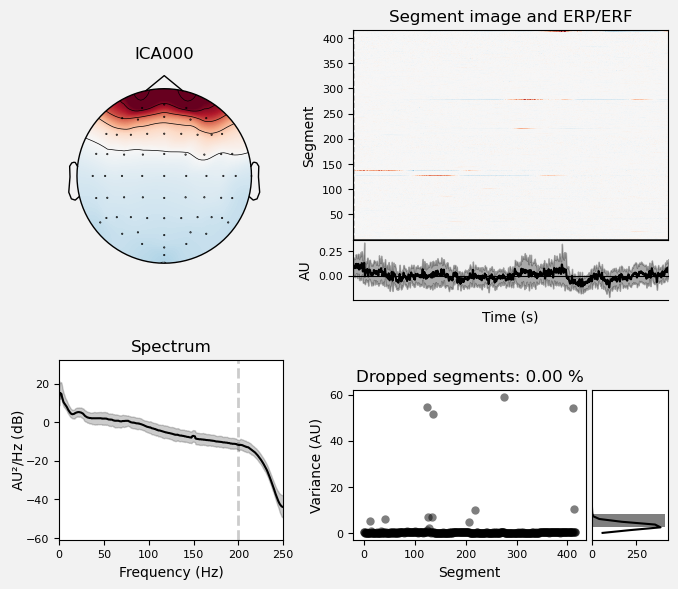

Creating RawArray with float64 data, n_channels=29, n_times=933888
    Range : 0 ... 933887 =      0.000 ...   911.999 secs
Ready.


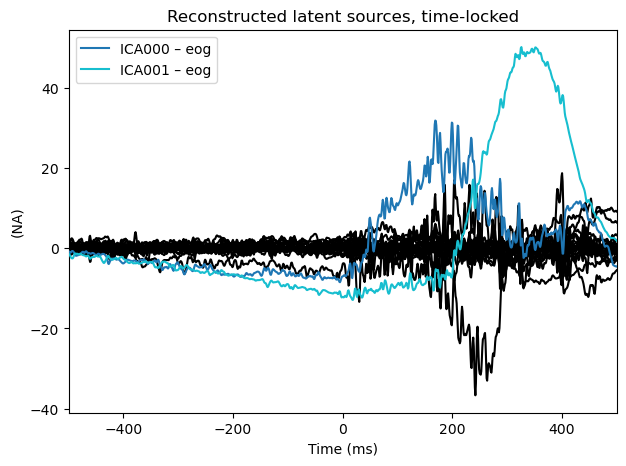

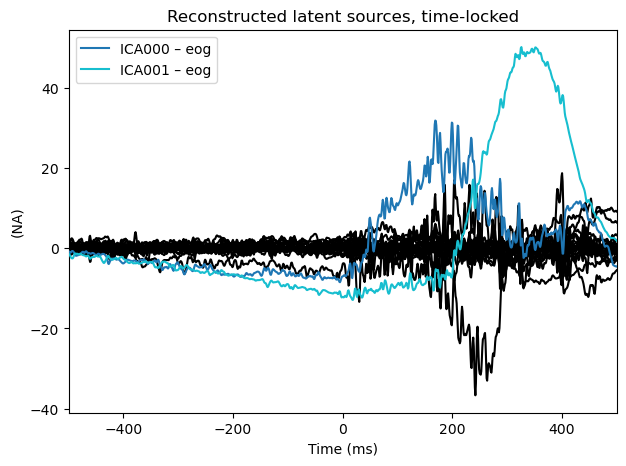

In [19]:
#Find ICA component associated with blink artefacts
ica.exclude = []
eog_evoked = create_eog_epochs(raw_bandpass).average()
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw_bandpass)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw_bandpass, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw_bandpass, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

In [ ]:
# plot ICAs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw_bandpass, show_scrollbars=False)

# Exlure les icas

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


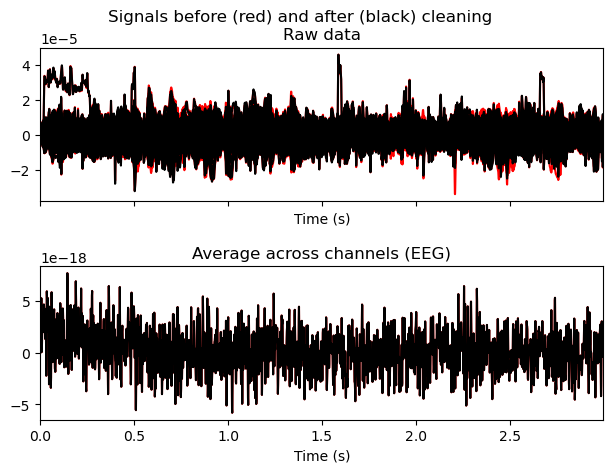

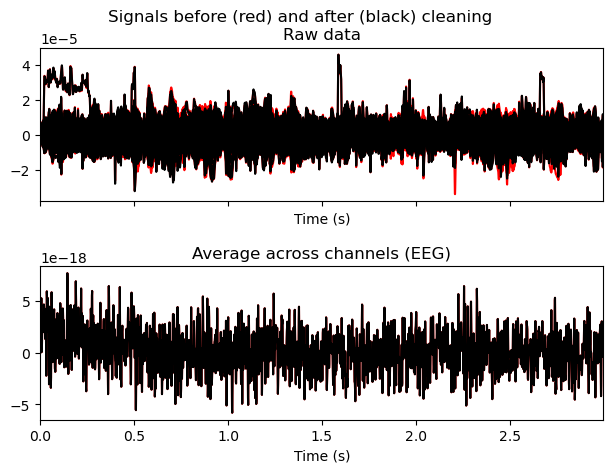

In [20]:
# Compare le signal avant et après le retrait de composantes
ica.plot_overlay(raw_bandpass, exclude=[0,1], picks='eeg')

In [21]:
# exclure composantes
ica.apply(raw_bandpass,exclude=[0,1])

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawEDF | SBallonge.bdf, 73 x 933888 (912.0 s), ~520.2 MB, data loaded>

# Epochs

In [22]:
# segmente le signal en epochs (cVEMPs intervalle de temps allant de -0.03s avant le stim à +0,2s après le stim)
#baseline
baseline= (-0.05,0)
epochs = mne.Epochs(raw_bandpass, events, event_id=event_dict , tmin=-0.05, tmax=0.3, picks=picks_eeg,baseline=baseline,
                    preload=True)
# Visualise les epochs (retirer les epochs bruitées)
fig = epochs.plot(events=events)

Not setting metadata
2400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2400 events and 359 original time points ...
0 bad epochs dropped


In [23]:
reject_criteria = dict(eeg=100e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF8', 'F2', 'F4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'F4']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P1', 'P3', 'PO3', 'Pz']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P1', 'P3', 'PO3']
    Rejecting  epoch based on EEG : ['P1', 'P3', 'PO3']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['F8']
    

Number of events,2376
Events,2500Hz105dB: 598500Hz105dB: 594500Hz60dB: 592mask500Hz90dB: 592
Time range,-0.050 – 0.300 sec
Baseline,-0.050 – 0.000 sec


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [24]:
# sauvegarder le fichier epochs après le retrait des badepochs
epochs.save('D:/Stage_M2/SBallonge_epochs-epo.fif')

In [ ]:
epochs.plot_drop_log()

In [ ]:
epochs = mne.read_epochs('D:\Stage_M2_Paul\Data participants Paul 2023\LS\LSallonge_epochs-epo.fif',preload=True)

In [ ]:
epochs

# Réponses moyennées pour un sujet

In [25]:
bip105dB500Hz = epochs['500Hz105dB'].average()
mask = epochs['mask500Hz90dB'].average()
bip60db500Hz = epochs['500Hz60dB'].average()
bip105dB2500Hz = epochs['2500Hz105dB'].average()

In [ ]:
%matplotlib qt
LPallonge_average_notchfilter_bip105dB500Hz = bip105dB500Hz.plot()
LPallonge_average_notchfilter_mask = mask.plot(spatial_colors=True)
LPallonge_average_notchfilter_bip60db500Hz = bip60db500Hz.plot(spatial_colors=True)
LPallonge_average_notchfilter_bip105dB2500Hz = bip105dB2500Hz.plot(spatial_colors=True)

In [26]:
%matplotlib qt

In [27]:
# Compare EPs
import matplotlib.pyplot as plt 
evokeds = dict(bip105dB500Hz=bip105dB500Hz,mask=mask,bip105dB2500Hz=bip105dB2500Hz,bip60db500Hz=bip60db500Hz)
picks = ['FCz']
colors = dict(mask="Purple",bip105dB500Hz="CornFlowerBlue",bip60db500Hz="Crimson",bip105dB2500Hz="green")

mne.viz.plot_compare_evokeds(evokeds,picks=picks,ylim=dict(eeg=[-2,2]),invert_y=True,colors=colors)

plt.text(0.0425, -5.5, 'N*', fontsize=10, color='blue')
plt.text(0.0525, -5.5, 'P*', fontsize=10, color='blue')

plt.show()

In [ ]:
evokeds_conditions = dict(bip105dB500Hz=list(epochs['500Hz105dB'].iter_evoked()), 
                    bip105dB2500Hz = list(epochs['2500Hz105dB'].iter_evoked()),
                     bip60db500Hz =list(epochs['500Hz60dB'].iter_evoked()),
                     mask=list(epochs['mask500Hz90dB'].iter_evoked()))
                            
picks = ['FCz']
colors = dict(mask="Purple",bip105dB500Hz="CornFlowerBlue",bip60db500Hz="Crimson",bip105dB2500Hz="green")

fig, ax = plt.subplots()

mne.viz.plot_compare_evokeds(
    evokeds_conditions,
    picks=picks,
    ylim=dict(eeg=[-2,2]),
    invert_y=True,
    colors=colors,
    ci=True, # Afficher les intervalles de confiance
    axes=ax
)

# Ajouter une ligne verticale pour N*
ax.axvline(x=0.042, ymin=-6, ymax=6, color='blue', linestyle='--')

# Ajouter une ligne verticale pour P*
ax.axvline(x=0.052, ymin=-6, ymax=6, color='blue', linestyle='--')

# Ajouter une légende pour les lignes N* et P*
plt.text(0.0425, -5.5, 'N*', fontsize=10, color='blue')
plt.text(0.0525, -5.5, 'P*', fontsize=10, color='blue')

plt.show()

In [28]:
# sauvegarde les figures des réponses moyennées pour chaque type de son
bip105dB500Hz.save('D:\Stage_M2/SBallonge_bip105dB500Hz-ave.fif')
bip105dB2500Hz.save('D:\Stage_M2/SBallonge_bip105dB2500Hz-ave.fif')
bip60db500Hz.save('D:\Stage_M2/SBallonge_bip60dB500Hz-ave.fif')
mask.save('D:\Stage_M2/SBallonge_mask-ave.fif')

# Lire evokeds d'un sujet

In [ ]:
%matplotlib qt
import mne
import matplotlib.pyplot as plt

# Charger le fichier
Bip105dB500Hz = 'D:/Stage_M2/EN/ENassis_bip105dB500Hz-ave.fif'
Mask = 'D:/Stage_M2/EN/ENassis_mask-ave.fif'
Bip60dB500Hz = 'D:/Stage_M2/EN/ENassis_bip60dB500Hz-ave.fif'
Bip105dB2500Hz = 'D:/Stage_M2/EN/ENassis_bip105dB2500Hz-ave.fif'
# Lire les evokeds
evokeds = {
    'Bip105dB500Hz': mne.read_evokeds(LSassis_bip105dB500Hz)[0],
    'Mask': mne.read_evokeds(LSassis_mask)[0],
    'Bip105dB2500Hz': mne.read_evokeds(LSassis_bip105dB2500Hz)[0],
    'Bip60dB500Hz': mne.read_evokeds(LSassis_bip60dB500Hz)[0]
}
# Définir les couleurs correspondantes
colors = {
    'Bip105dB500Hz': 'CornFlowerBlue',
    'Mask': 'Purple',
    'Bip105dB2500Hz': 'green',
    'Bip60dB500Hz': 'Crimson'
}
# Plot evoked
picks = ['FCz']
mne.viz.plot_compare_evokeds(evokeds, picks=picks, colors=colors, invert_y=True)
plt.xlim(0, 0.300)
plt.ylim(-2, 2)
# Texte pour P13 et N23
ax.text(0.010, -105, 'P13', color='blue', fontsize=14)
ax.text(0.020, -105, 'N23', color='blue', fontsize=14)
# Augmentation de la taille de la police des axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Modification de la taille de la police pour les labels des axes
plt.xlabel('time (s)', fontsize=16)
plt.ylabel('µV', fontsize=16)
plt.show()

# Modifier la légende
#plt.legend(loc='upper right', fontsize='large')

In [ ]:
print(evoked)

In [ ]:
evoked.plot()